# **CDS Project: Part 2**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Identify and extract vulnerable code from software reposiroties
- Identify and extract non-vulnerabile code from software reposiroties.
- Select and apply pre-proceesing techniques.
- Create a dataset of security vulnerabilities.

## Materials
---

- Lecture Slides 3, 5 and 6.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- [ProjectKB GitHub repo](https://github.com/SAP/project-kb).
- PyDriller Documentation: [PyDriller](https://pydriller.readthedocs.io/en/latest/)

## Project Description
---

In this project, you will create your own dataset of security vulnerabilities. This dataset shoul be generated using the information contained in ProjectKB. ProjectKB is a repository created to enable the creation, management and aggregation of a distributed and collaborative knowledge base of vulnerabilities affecting open-source software written in Java programming language. This repository contains a list of CVEs and the corresponding commits that fix it. Usually the vulnerabilities are contained in a method. Your task is to use this repository to extract the vulnerable and fixed version of the methods.

###*Task 1*

- Download the ProjectKB repository (i.e., create a local copy by cloning it).
- 
- Locate the folder containing the CVEs and their corresponding fixing commits.

In [3]:
from git import Repo

repo_url = 'https://github.com/SAP/project-kb.git'
local_path = 'project-kb'

Repo.clone_from(repo_url, local_path)

<git.repo.base.Repo '/Users/asmaulhusnaurme/Downloads/project-kb/.git'>

In [5]:
import os
local_repo_path = 'vulnerability_branch_content'
remote_repo_url = 'https://github.com/SAP/project-kb.git'
branch_name = 'vulnerability-data'
# Clone the repository
Repo.clone_from(remote_repo_url, local_repo_path, branch=branch_name)

<git.repo.base.Repo '/Users/asmaulhusnaurme/Downloads/vulnerability_branch_content/.git'>

###*Task 2*

- Write a script that extracts (i) the repository URLs and (ii) corresponding fixing commit ID (hash) contained on each CVE.

In [6]:
import yaml
def parse_file(path):
    fixes_list = []
    with open(path, 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
    if 'fixes' in data:
        print("file: "+ str(path) + " has fix")
        fixes_key_content = data['fixes']
        # Loop through all fixes
        for fix in fixes_key_content:
            # Loop through all commits in each fix
            for commit in fix.get('commits', []):
                repo_url = commit.get('repository')
                commit_id = commit.get('id')
                if repo_url and commit_id:
                    fixes_list.append([repo_url, commit_id])
                    print('repository: '+str(repo_url)+'\n'+'commit id: '+str(commit_id))
        return fixes_list if fixes_list else None
    else:
        print("file: "+ str(path) + " does not have fix")
        return None

In [7]:
import os
folder_path = 'vulnerability_branch_content/statements'

count = 0
fixes = []
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        if file_name.endswith('.yaml'):
            file_path = os.path.join(root, file_name)
            fixes.append(parse_file(file_path))

print(len(fixes))
filtered_fixes = [x for x in fixes if x is not None]
filtered_fixes = [x for x in filtered_fixes if x[0] !='https://github.com/apache/tomcat/']
filtered_fixes = [x for x in filtered_fixes if x[0] !='https://github.com/blynkkk/blynk-server']

print(len(filtered_fixes))
print(filtered_fixes[0])

file: vulnerability_branch_content/statements/CVE-2018-15560/statement.yaml has fix
repository: https://github.com/Legrandin/pycryptodome
commit id: d1739c62b9b845f8a5b342de08d6bf6e2722d247
file: vulnerability_branch_content/statements/CVE-2020-9547/statement.yaml has fix
repository: https://github.com/FasterXML/jackson-databind
commit id: 9f4e97019fb0dd836533d0b6198c88787e235ae2
file: vulnerability_branch_content/statements/CVE-2018-11762/statement.yaml has fix
repository: https://github.com/apache/tika
commit id: a09d853dbed712f644e274b497cce254f3189d57
file: vulnerability_branch_content/statements/CVE-2019-12419/statement.yaml has fix
repository: https://github.com/apache/cxf
commit id: 6bf89927d3e07197d49453b00d673eadce696cf
repository: https://github.com/apache/cxf
commit id: db6069667708a59c75a785f310d4a2df3698122
repository: https://github.com/apache/cxf
commit id: 337609d81a9f53e7680cb79d9ab733a79f4cd76
file: vulnerability_branch_content/statements/CVE-2019-17359/statement.yaml

In [8]:

import csv

with open('fixes_output.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Repository URL', 'Commit ID'])  # Write header

    for item in filtered_fixes:
        if isinstance(item, list) and len(item) == 2:
            writer.writerow(item)

print(f"CSV export complete: {len(filtered_fixes)} entries written to fixes_output.csv")


CSV export complete: 1248 entries written to fixes_output.csv


###*Task 3*

- Using the URL, identify and extract the method where the "fix" is introduced. 
- Locate the previous version of the file and extract the same function (i.e., the "vulnerable" version of the same function). 

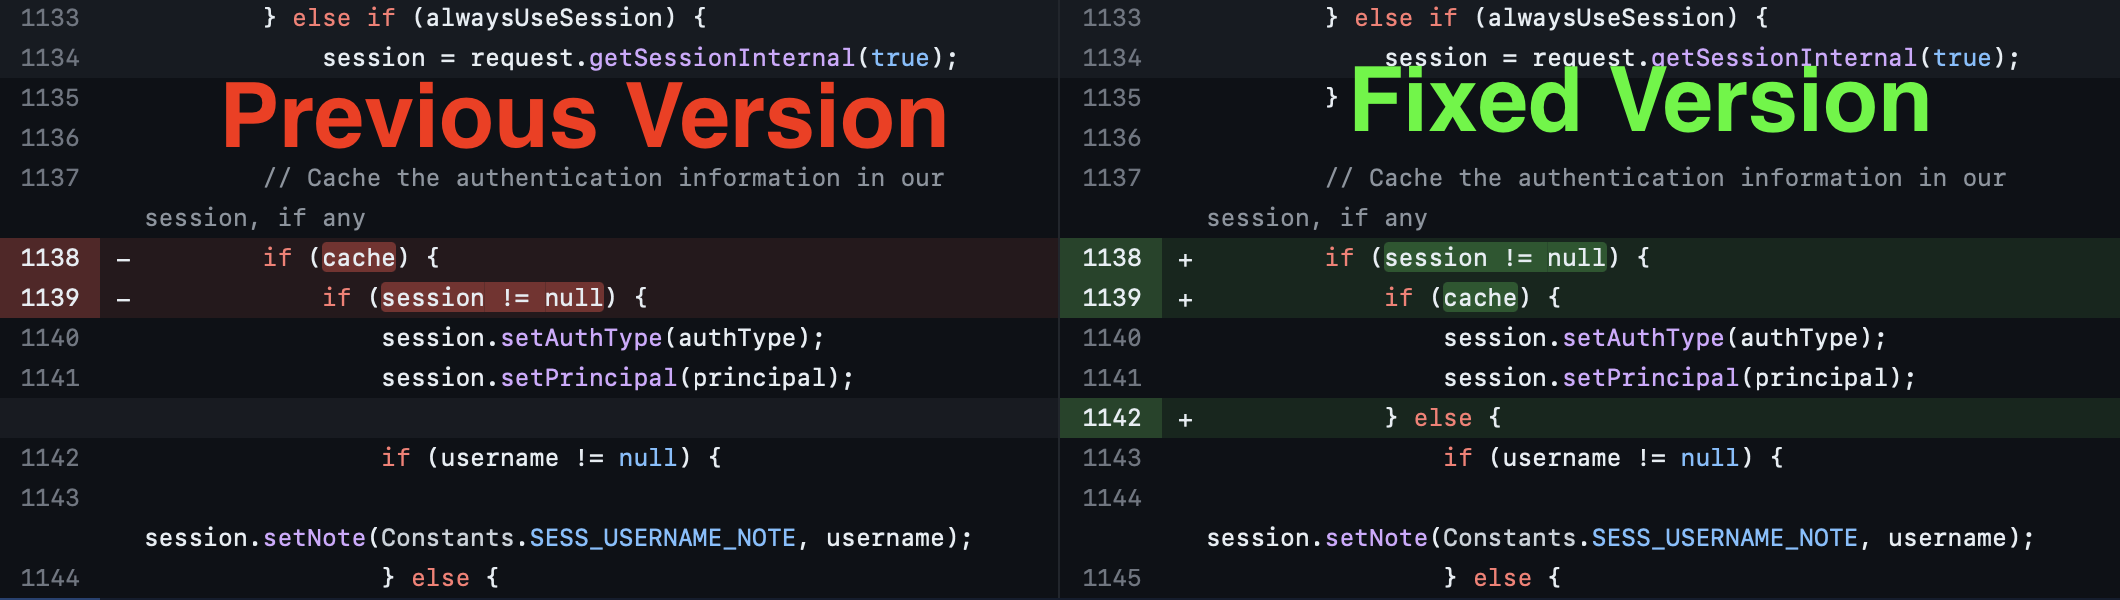

In [15]:
import os
import csv
from git import Repo
from pydriller import Repository

REPO_URL = "https://github.com/apache/geode"
LOCAL_PATH = "/Volumes/T7/clone_repo"
CSV_OUTPUT = "label_dataset_fixes.csv"

# Clone if not already cloned
if not os.path.exists(LOCAL_PATH):
    print(f"Cloning {REPO_URL} into {LOCAL_PATH}...")
    Repo.clone_from(REPO_URL, LOCAL_PATH)
else:
    print(f"Repository already exists at {LOCAL_PATH}")

def indent(code, prefix='    '):
    return '\n'.join(prefix + line for line in code.split('\n'))

def is_fix_commit(msg):
    return any(word in msg.lower() for word in ['fix', 'bug', 'issue', 'patch'])

# === Process Fix Commits ===
csv_data = []

repo = Repository(LOCAL_PATH)
max_commits = 100 # <-- only taking 100 fix commits
count = 0

for commit in repo.traverse_commits():
    if count >= max_commits:
        break

    if not is_fix_commit(commit.msg):
        continue
        
    java_files = [mf for mf in commit.modified_files if mf.filename.endswith('.java')]
    
    if not java_files:
        continue  

    count += 1
    print(f"\n[{count}/{max_commits}] Analyzing fix commit: {commit.hash} - {commit.msg[:50]}")

    count += 1  # Increment only when it's a fix commit
    print(f"\n[{count}/{max_commits}] Analyzing fix commit: {commit.hash} - {commit.msg[:50]}")

    for modified_file in commit.modified_files:
        if not modified_file.filename.endswith('.java'):
            continue
        methods_before = modified_file.methods_before
        changed_methods = modified_file.changed_methods

        for changed_method in changed_methods:
            match = None
            for method_before in methods_before:
                if method_before.name == changed_method.name:
                    match = method_before
                    break

            after_start = changed_method.start_line
            after_end = changed_method.end_line
            after_lines = (modified_file.source_code or '').split('\n')
            after_code = '\n'.join(after_lines[after_start - 1:after_end])

            if match:
                before_start = match.start_line
                before_end = match.end_line
                before_lines = (modified_file.source_code_before or '').split('\n')
                before_code = '\n'.join(before_lines[before_start - 1:before_end])
            else:
                before_code = '[no matching method found]'
                before_start = before_end = None

            print(f"\nFile: {modified_file.filename}")
            print("Before, function and code:")
            print(indent(before_code))
            print(f"Start Line:{after_start}")
            print(f"End Line:{after_end}")
            print("\nAfter, function and code:")
            print(indent(after_code))
            print("=" * 80)

            if before_code != '[no matching method found]':
                csv_data.append([before_code, True])   # True = buggy
            csv_data.append([after_code, False])       # False = fixed


if not csv_data:
    print("\nNo Java method-level changes found in fix commits.")
else:
    with open(CSV_OUTPUT, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['source code', 'label'])
        writer.writerows(csv_data)
    print(f"\nSaved output to {CSV_OUTPUT}")


Repository already exists at /Volumes/T7/clone_repo

[1/100] Analyzing fix commit: 08182b1830091d7a0ccc6288eb49ba39a7a9b9a0 - [GEODE-38] Add gfsh init script support for .gfsh2

[2/100] Analyzing fix commit: 08182b1830091d7a0ccc6288eb49ba39a7a9b9a0 - [GEODE-38] Add gfsh init script support for .gfsh2

File: Gfsh.java
Before, function and code:
      public static Gfsh getInstance(boolean launchShell, String[] args, GfshConfig gfshConfig)
        throws ClassNotFoundException, IOException
      {
        if (instance == null) {
          synchronized (INSTANCE_LOCK) {
            if (instance == null) {
              instance = new Gfsh(launchShell, args, gfshConfig);
            }
          }
        }
    
        return instance;
      }
Start Line:301
End Line:314

After, function and code:
      public static Gfsh getInstance(boolean launchShell, String[] args, GfshConfig gfshConfig)
        throws ClassNotFoundException, IOException
      {
        if (instance == null) {
        

### *Task 4*
-  Create a labeled dataset using the non-vulnerable and  vulnerable functions extracted in **Step 3**.
- Find a suitable file format for the dataset (CSV, JSON, HDF5, etc.).
- The dataset should contain the following structure:
  - function code
  - boolean label: vulnerable / non-vulnerable

In [3]:

# TODO: Organize the data collected in the previous step into a labeled dataset

# TODO: Save the dataset to a file in a suitable format.import pandas as pd

import pandas as pd
df = pd.read_csv('label_dataset_fixes.csv')

# Check the format
# Show initial sample
print("Sample rows:\n", df.head())
print("\nLabel counts (before mapping):\n", df['label'].value_counts())
# Map boolean to string labels
df['label'] = df['label'].map({True: 'vulnerable', False: 'non-vulnerable'})

print("Sample rows:\n", df.head())
print("\nLabel counts (after mapping):\n", df['label'].value_counts())
# drop duplicates
df = df.drop_duplicates()

#  remove empty or very short functions
df = df[df['source code'].str.strip().str.len() > 10]

# Save cleaned dataset
df.to_csv('label_dataset_final.csv', index=False)
print("\n Cleaned dataset saved to label_dataset_final.csv")


Sample rows:
                                          source code  label
0    public static Gfsh getInstance(boolean launc...   True
1    public static Gfsh getInstance(boolean launc...  False
2    private void executeInitFileIfPresent() {\n\...  False
3    public GfshConfig() {\n    this(HISTORY_FILE...   True
4  \n  public GfshConfig(String historyFileName, ...  False

Label counts (before mapping):
 label
False    1540
True     1151
Name: count, dtype: int64
Sample rows:
                                          source code           label
0    public static Gfsh getInstance(boolean launc...      vulnerable
1    public static Gfsh getInstance(boolean launc...  non-vulnerable
2    private void executeInitFileIfPresent() {\n\...  non-vulnerable
3    public GfshConfig() {\n    this(HISTORY_FILE...      vulnerable
4  \n  public GfshConfig(String historyFileName, ...  non-vulnerable

Label counts (after mapping):
 label
non-vulnerable    1540
vulnerable        1151
Name: count, dtype: i

In [12]:
from datetime import datetime
from pydriller import Repository

LOCAL_REPO_PATH = "/Volumes/T7/clone_repo"
MAX_COMMITS = 100

def is_fix_commit(msg):
    return any(word in msg.lower() for word in ['fix', 'bug', 'issue', 'patch'])

commit_dates = []

repo = Repository(LOCAL_REPO_PATH)

for commit in repo.traverse_commits():
    if len(commit_dates) >= MAX_COMMITS:
        break
    if is_fix_commit(commit.msg):
        commit_dates.append(commit.committer_date)

if commit_dates:
    earliest = min(commit_dates)
    latest = max(commit_dates)
    print("Earliest commit date:", earliest.strftime("%Y-%m-%d"))
    print("Latest commit date:", latest.strftime("%Y-%m-%d"))
else:
    print("No fix commits found.")


Earliest commit date: 2015-05-11
Latest commit date: 2015-09-25
